In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
import h5py

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

train_data_x = np.genfromtxt('data_x.csv', delimiter=',')

#train_data_y = np.genfromtxt('y_train.csv', delimiter=',')

data_x = []
for a in train_data_x:
    data_x.append(a)

data_x = np.array(data_x)
x = []
for a in data_x:
    for b in a:
        x.append(b)
plt.xlim(-10, 15)
plt.hist(x, normed=True, bins=1500)


discriminator_input_dim = 8 * 8
discriminator_output_dim = 1

generator_input_dim = 100
generator_output_dim = 8 * 8

hidden_layer_dim = 128

epoch_dim = 50000
batch_size = 100

x_discriminator = tf.placeholder("float32", shape=[None, discriminator_input_dim])

x_generator = tf.placeholder("float32", shape=[None, generator_input_dim])

D_W1 = tf.Variable(xavier_init([discriminator_input_dim, hidden_layer_dim]))
D_B1 = tf.Variable(tf.zeros(shape=[hidden_layer_dim]))

D_W2 = tf.Variable(xavier_init([hidden_layer_dim, discriminator_output_dim]))
D_B2 = tf.Variable(tf.zeros(shape=[discriminator_output_dim]))

theta_D = [D_B1, D_B2, D_W1, D_W2]

G_W1 = tf.Variable(xavier_init([generator_input_dim, hidden_layer_dim]))
G_B1 = tf.Variable(tf.zeros(shape=[hidden_layer_dim]))

G_W2 = tf.Variable(xavier_init([hidden_layer_dim, generator_output_dim]))
G_B2 = tf.Variable(tf.zeros(shape=[generator_output_dim]))

theta_G = [G_B1, G_B2, G_W1, G_W2]



def discriminator(x):
    discriminator_hidden = tf.nn.relu(tf.matmul(x, D_W1) + D_B1)
    discriminator_output = tf.matmul(discriminator_hidden, D_W2) + D_B2
    return discriminator_output


def generator(x):
    generator_hidden = tf.nn.relu(tf.matmul(x, G_W1) + G_B1)
    generator_output = tf.matmul(generator_hidden, G_W2) + G_B2
    generator_output_activated = tf.nn.sigmoid(generator_output) * 4
    return generator_output_activated


discriminator_logit_real = discriminator(x_discriminator)
discriminator_logit_fake = discriminator(generator(x_generator))
discriminator_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logit_real, labels=tf.ones_like(discriminator_logit_real)))
discriminator_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logit_fake, labels=tf.zeros_like(discriminator_logit_fake)))
discriminator_loss = discriminator_loss_real + discriminator_loss_fake
discriminator_optimizer = tf.train.AdamOptimizer().minimize(discriminator_loss, var_list=theta_D)

generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logit_fake, labels=tf.ones_like(discriminator_logit_fake)))
generator_optimizer = tf.train.AdamOptimizer().minimize(generator_loss, var_list=theta_G)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)


def sample(a, b):
    return np.random.uniform(-1., 1., size=[a, b])

with open('decoder_a.json', 'r') as f:
    decoder = model_from_json(f.read())
    decoder.load_weights("decoder_a.h5")

counter = 0
for epoch in range(epoch_dim):
    batch_x = data_x[counter: counter+batch_size]
    counter += batch_size
    if counter >= len(data_x):
        counter = 0
    if epoch % 10000 == 0:
        print(epoch)
        continue
        n = 10
        test_pict = generator(x_generator).eval(feed_dict={x_generator:sample(n, generator_input_dim)})
        test_pict = np.array(test_pict)
        decoded_imgs = decoder.predict(test_pict)
        plt.figure(figsize=(20, 8))
        plt.gray()    
        for i in range(0, n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(decoded_imgs[i].reshape(28, 28))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

    sess.run([discriminator_optimizer, discriminator_loss], feed_dict={x_discriminator: batch_x, x_generator:sample(batch_size, generator_input_dim)})
    sess.run([generator_optimizer, generator_loss], feed_dict={x_generator:sample(batch_size, generator_input_dim)})

0
10000
20000
30000
40000


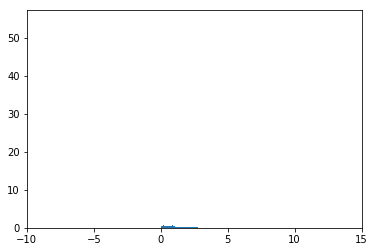

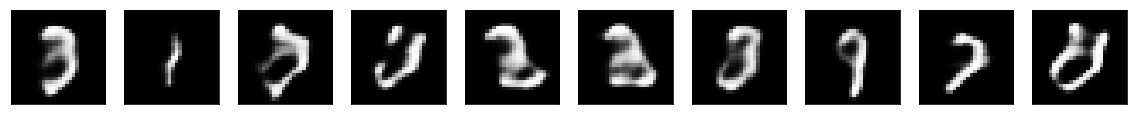

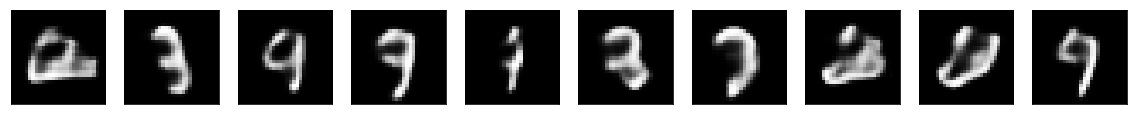

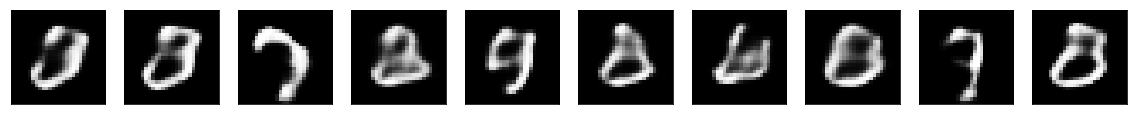

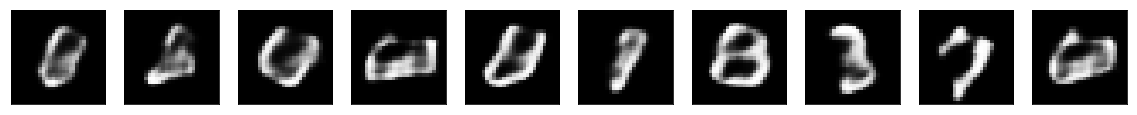

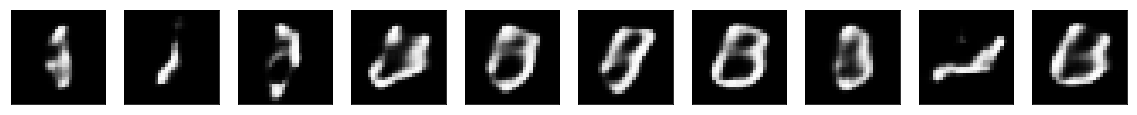

In [ ]:
plt.gray()    
for ax in range(10):    
    n = 10
    test_pict = generator(x_generator).eval(feed_dict={x_generator:sample(n, generator_input_dim)})
    test_pict = np.array(test_pict).reshape(10, 4, 4, 4)
    decoded_imgs = decoder.predict(test_pict)
    plt.figure(figsize=(20, 8))
    for i in range(0, n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
